Author: Abdelmalik Moujahid -- abdelmalik.moujahid@uc3m.es

Date: March 15, 2017

<b> Solved by: Alessandro La Corte </b>
<br/>
<b> Email: 100355025@alumnos.uc3m.es </b>


# Machine Learning

## Session 4: Predicting house prices with GP


The aim of this session is to solve a real data problem using the Gaussian Process implementation of GPy. The documentation of GPy is avaialable from the [SheffieldML github page](https://github.com/SheffieldML/GPy) or from [this page](http://gpy.readthedocs.org/en/latest/). The problem is the prediction of the house prices using the Housing Data Set from  <a href = https://archive.ics.uci.edu/ml/datasets/Housing>  UCI repository</a> that you can also download from scikit learn <a href = http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html> here</a>.


In [53]:
#All imports

import numpy                   as np
import GPy
import matplotlib.pyplot       as plt
import math
from sklearn.datasets          import load_boston
from sklearn                   import cross_validation
from matplotlib                import pyplot as plt 
from sklearn.model_selection   import LeaveOneOut


In [54]:
def rmse(Y, Ystar):
        return np.sqrt(np.mean((Y-Ystar)**2))

### 1. Loading and preparing the data

* Download the dataset
* Divide the dataset into train (400) and test (106) datasets
* Check the range of prices in the train and test datasets

In [51]:
boston = load_boston()

X = boston.data
# y = boston.target
y = boston.target

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=106, random_state=42)

#The kernels requiere the shape of y to be of (number,1)
y_train = np.reshape(y_train, (y_train.size,1))
y_test = np.reshape(y_test, (y_test.size,1))

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

print "The range of values of the X Train dataset ({},{})".format(np.amin(X_train), np.amax(X_train))
print "The range of values of the X Test dataset ({},{})".format(np.amin(X_test), np.amax(X_test))

print "The range of values of the y Train dataset ({},{})".format(np.amin(y_train), np.amax(y_train))
print "The range of values of the y Test dataset ({},{})".format(np.amin(y_test), np.amax(y_test))


(400, 13)
(106, 13)
(400, 1)
(106, 1)
The range of values of the X Train dataset (0.0,711.0)
The range of values of the X Test dataset (0.0,711.0)
The range of values of the y Train dataset (5.0,50.0)
The range of values of the y Test dataset (5.0,50.0)



### 2. Setting and optimizing the model

On the training data set:

a) Build a GP regression model based on an exponentiated quadratic covariance function

b) Fit the covariance function parameters and noise to the data  

On the test data set:

c) Plot and evaluate the prediction error using the opmitized parameters

d) Try to combine various covariance functions using the element-wise product or the sum of two kernels, and repeat steps b) and c). Comments the results.

<h1><b> Build a GP regression model based on an exponentiated quadratic covariance function</b></h1>

In [4]:
# The data has 13 dimensions
kern = GPy.kern.RBF(input_dim=13)
kern

<h1><b>Fit the covariance function parameters and noise to the data </b></h1>

Using the train set a Gaussian process regressor is fitted using the previous kernel:

In [5]:
model = GPy.models.GPRegression(X_train, y_train, kern)
print model


Name : GP regression
Objective : 61299.2448933
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Optimizing the model fitted only once and showing the fitted parameters (variance, lengthscale, noise)

In [8]:
#Doing one optimization
model.optimize()
model.log_likelihood.im_self

Now running several optimization over the constraint positive parameters:

In [9]:
#Running several optimizations
model.constrain_positive('.*rbf_variance')
model.constrain_positive('.*lengthscale' )
model.constrain_positive('.*noise')
model.optimize_restarts(num_restarts=5)
print model

Optimization restart 1/5, f = 1189.55703709
Optimization restart 2/5, f = 1189.55703707
Optimization restart 3/5, f = 1189.55703709
Optimization restart 4/5, f = 1189.55703714
Optimization restart 5/5, f = 1189.5570371

Name : GP regression
Objective : 1189.55703707
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  1782853.57655  |      +ve      |        
  rbf.lengthscale          |  427.585997078  |      +ve      |        
  Gaussian_noise.variance  |  8.58745824696  |      +ve      |        


<h1><b>Plot and evaluate the prediction error using the opmitized parameters </b></h1>

Lets take a look a the optimized model:

In [10]:
print model


Name : GP regression
Objective : 1189.55703707
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  1782853.57655  |      +ve      |        
  rbf.lengthscale          |  427.585997078  |      +ve      |        
  Gaussian_noise.variance  |  8.58745824696  |      +ve      |        


Given that the *model* is optimizied, lets first plot several prediction error plots:

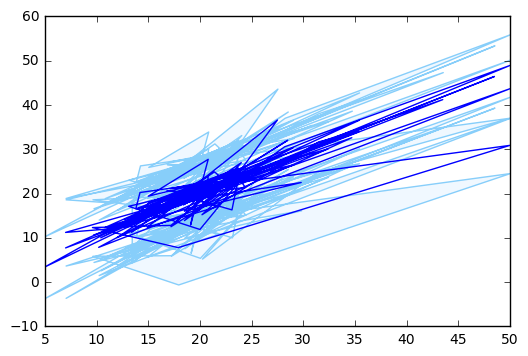

In [30]:
%matplotlib inline

[mean,cov] = model.predict(X_test, full_cov=False)

lower =mean-2*np.sqrt(cov)
upper =mean+2*np.sqrt(cov)

plt.fill_between(y_test[:,0],lower[:,0],upper[:,0],color='AliceBlue',edgecolor='LightSkyBlue')
plt.plot(y_test,mean,'b')
plt.show()

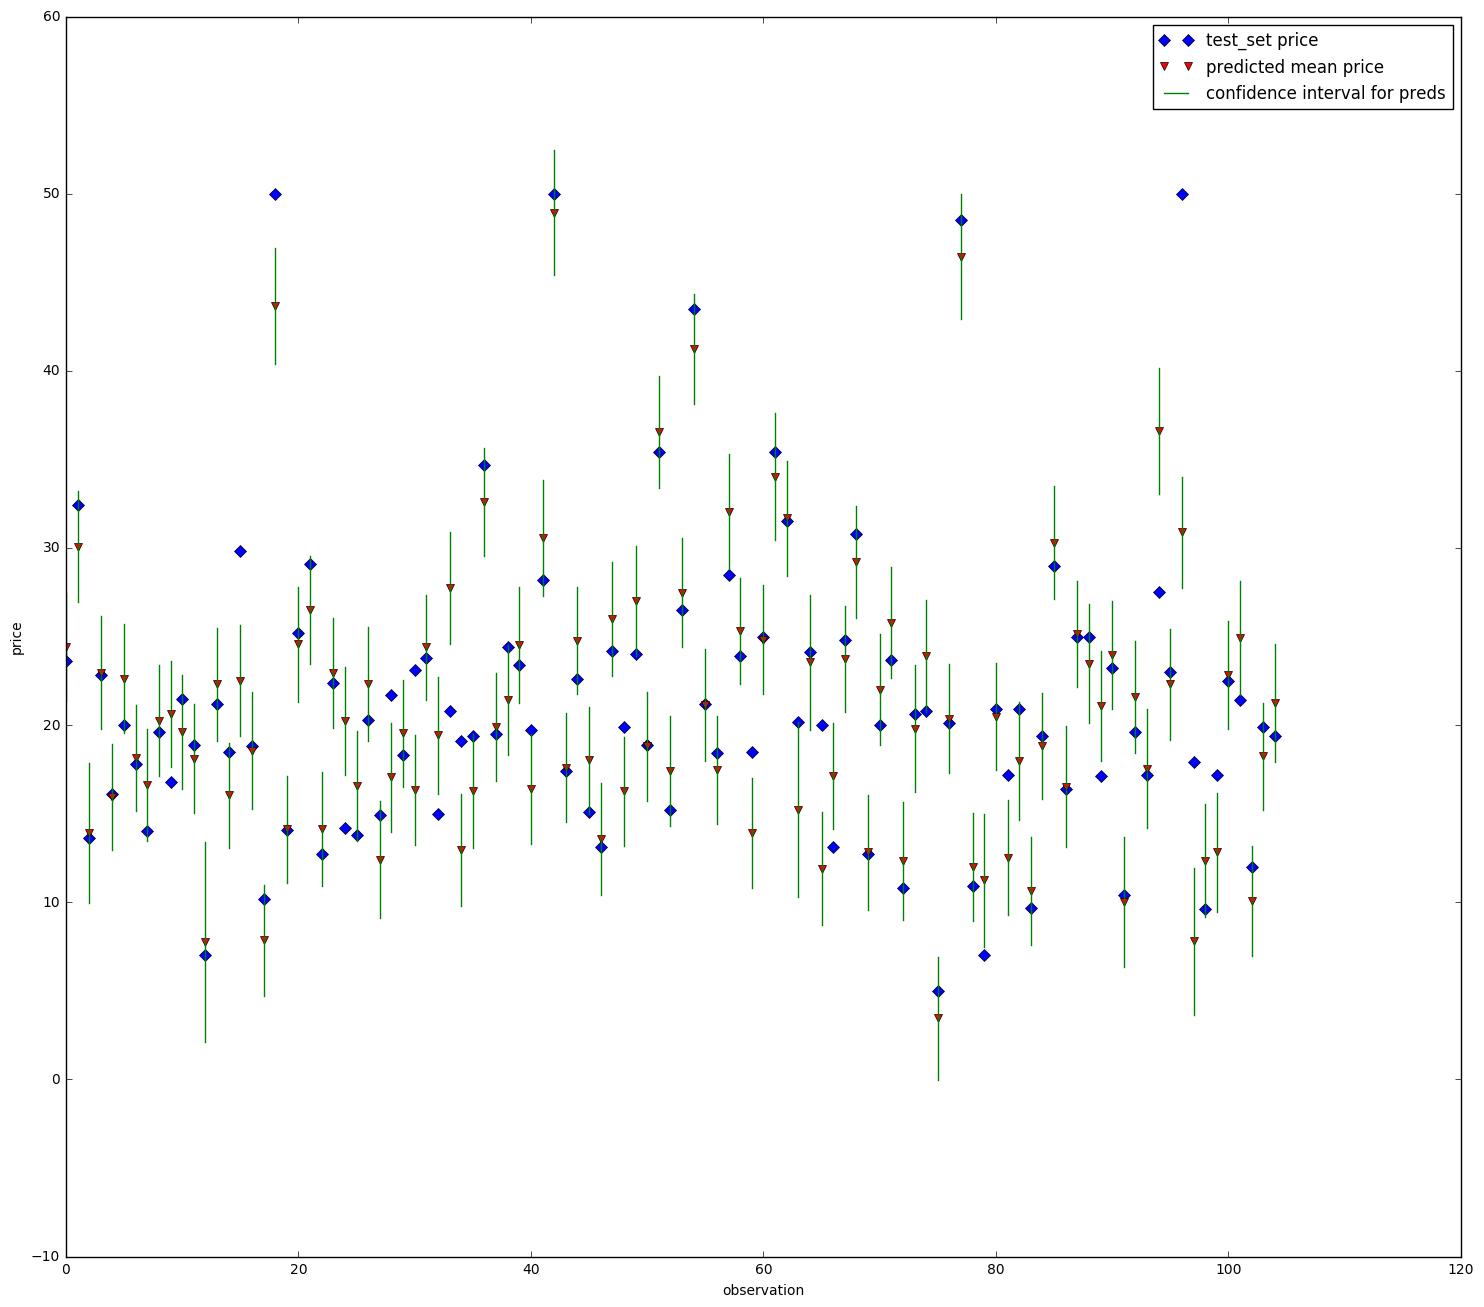

In [12]:
%matplotlib inline
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in np.arange(0,len(y_test)-1):
    plt.plot(i, y_test[i][0], 'Db', label='test_set price' if i == 0 else "")
    plt.plot(i, mean[i][0], 'vr', label='predicted mean price' if i == 0 else "")
    plt.plot([i, i],
             [mean[i][0] - cov[i][0]**0.5, mean[i][0] + cov[i][0]**0.5],
             '-g', linewidth=1, label='confidence interval for preds' if i == 0 else "")
plt.xlabel('observation')
plt.ylabel('price')
plt.legend()
plt.show()

To evaluate the error the following metrics are followed:

In [39]:
myrmse = rmse(y_test, mean)
print "The RMSE error is {}".format(myrmse)

pred_density = np.mean(model.log_predictive_density(X_test, y_test))
print "The predictive density is {}".format(pred_density)

The RMSE error is 3.54822460514
The predictive density is -2.68584427017


<h1><b>Try to combine various covariance functions using the element-wise product or the sum of two kernels, and repeat steps b) and c). Comments the results. </b></h1>

Lets combine a RBF kernel with a Bias kernel:

In [41]:
ckern  = GPy.kern.RBF( input_dim= 13 ) + GPy.kern.Bias(input_dim=13)
cmodel = GPy.models.GPRegression(X_train, y_train, ckern)
print cmodel


Name : GP regression
Objective : 9455.515878
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  sum.rbf.variance         |    1.0  |      +ve      |        
  sum.rbf.lengthscale      |    1.0  |      +ve      |        
  sum.bias.variance        |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Run several optimizations:

In [43]:
#Running several optimizations
cmodel.constrain_positive('.*rbf_variance')
cmodel.constrain_positive('.*lengthscale' )
cmodel.constrain_positive('.*noise')
cmodel.optimize_restarts(num_restarts=5)
print cmodel

Optimization restart 1/5, f = 1188.78213052
Optimization restart 2/5, f = 1188.78380436
Optimization restart 3/5, f = 1188.8018826
Optimization restart 4/5, f = 1189.23934967
Optimization restart 5/5, f = 1188.78291208

Name : GP regression
Objective : 1188.78213052
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  sum.rbf.variance         |  2066433.75136  |      +ve      |        
  sum.rbf.lengthscale      |  448.810074911  |      +ve      |        
  sum.bias.variance        |  1205096.03147  |      +ve      |        
  Gaussian_noise.variance  |  8.63316565754  |      +ve      |        


Given the previous optimized model:

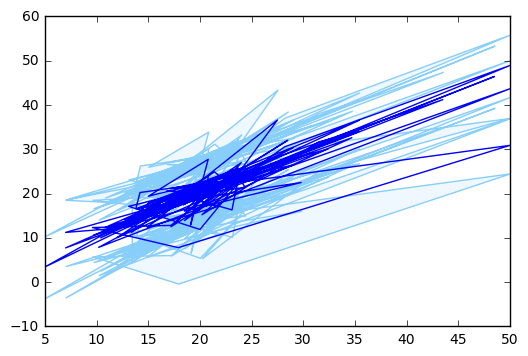

In [44]:
[cmean,ccov] = cmodel.predict(X_test, full_cov=False)

clower =cmean-2*np.sqrt(ccov)
cupper =cmean+2*np.sqrt(ccov)

plt.fill_between(y_test[:,0],clower[:,0],cupper[:,0],color='AliceBlue',edgecolor='LightSkyBlue')
plt.plot(y_test,mean,'b')
plt.show()

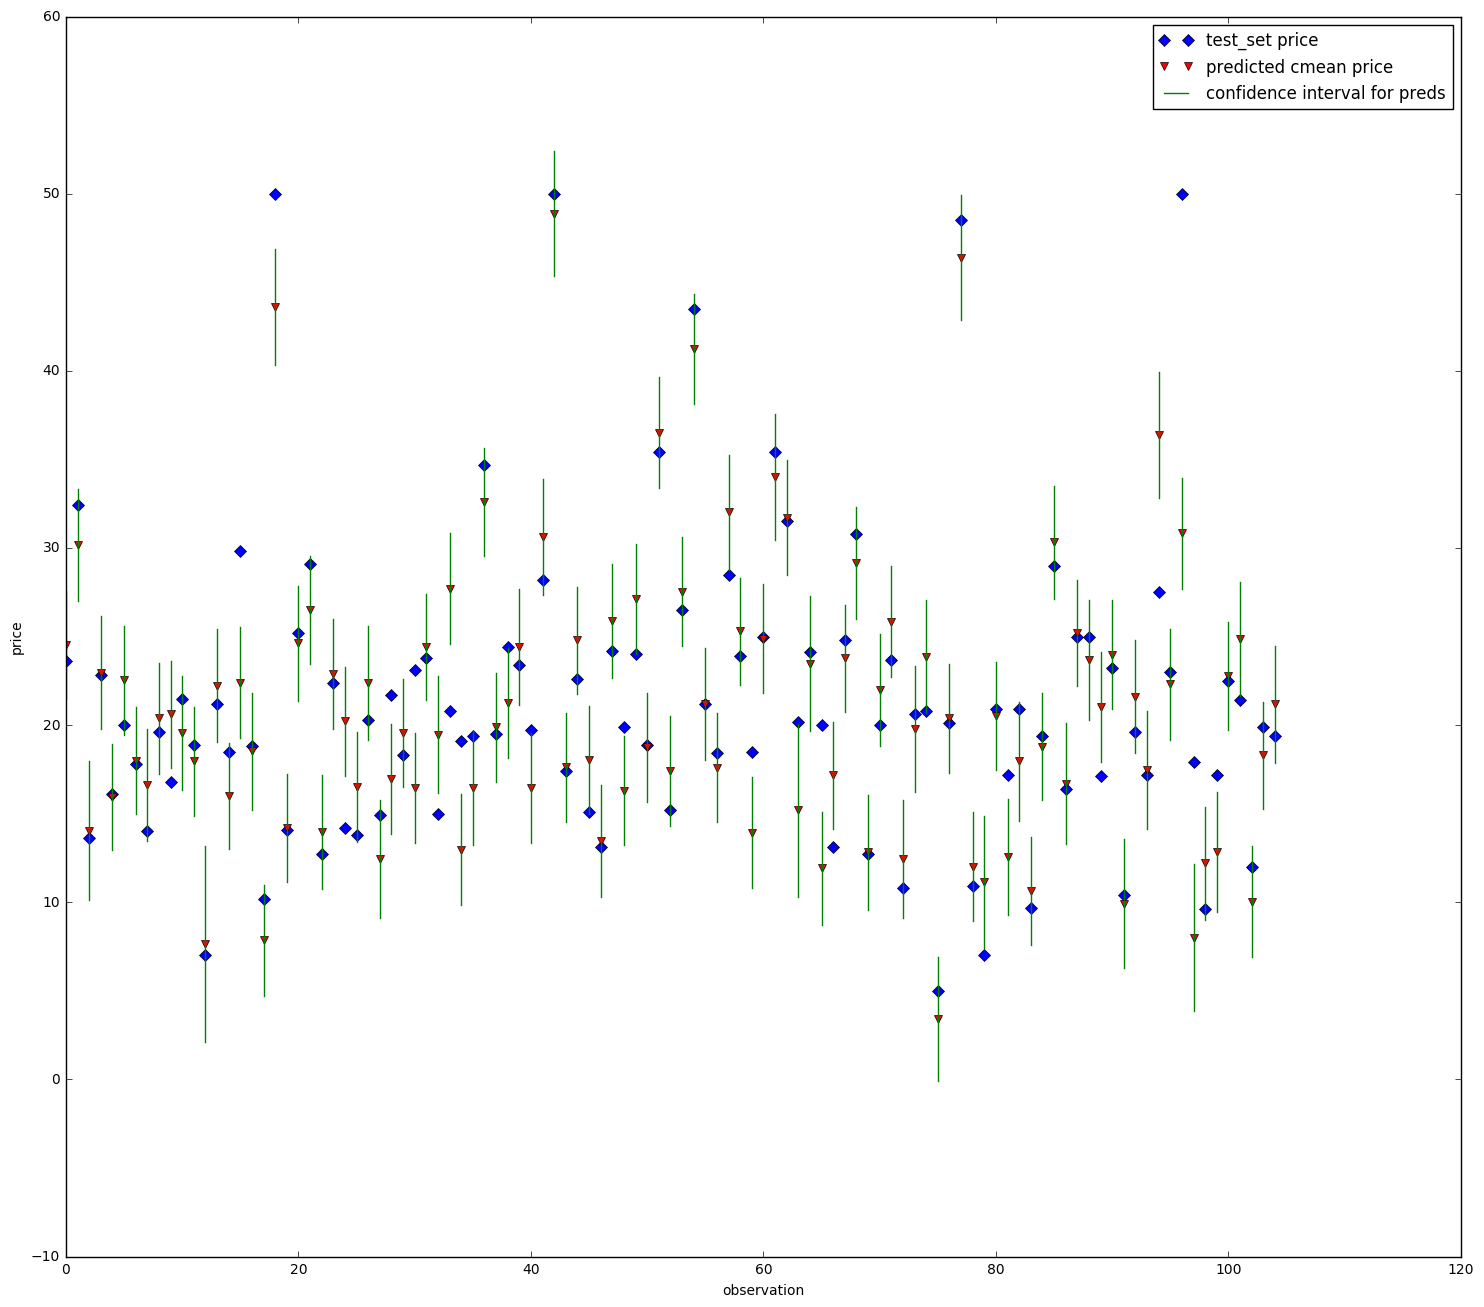

In [45]:
%matplotlib inline
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in np.arange(0,len(y_test)-1):
    plt.plot(i, y_test[i][0], 'Db', label='test_set price' if i == 0 else "")
    plt.plot(i, cmean[i][0], 'vr', label='predicted cmean price' if i == 0 else "")
    plt.plot([i, i],
             [cmean[i][0] - ccov[i][0]**0.5, cmean[i][0] + ccov[i][0]**0.5],
             '-g', linewidth=1, label='confidence interval for preds' if i == 0 else "")
plt.xlabel('observation')
plt.ylabel('price')
plt.legend()
plt.show()

In [46]:
myrmse = rmse(y_test, cmean)
print "The RMSE error is {}".format(myrmse)

pred_density = np.mean(cmodel.log_predictive_density(X_test, y_test))
print "The predictive density is {}".format(pred_density)

The RMSE error is 3.53750912397
The predictive density is -2.68240480747


### 3. Leave-one-out CV

Using the whole dataset, employ a LOO-CV to evaluate the prediction error

Caution: optimize only once the kernel parameters, and be concious that this is a lengthy operation

In [55]:
loo = LeaveOneOut()
i   = 1

#Declare kernel
cvkern = GPy.kern.RBF(input_dim=13)

for train_index, test_index in loo.split(X):    
    #Get the train and test data set, 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Reshape the y vector
    y_train = np.reshape(y_train, (y_train.size,1))
    y_test = np.reshape(y_test, (y_test.size,1))

    #Declare Gaussian Process regressor
    cvmodel = GPy.models.GPRegression(X_train, y_train, cvkern)

    #Optimize
    cvmodel.optimize()
    print cvmodel
    
    #Predict
    [cvmean,cvcov] = cvmodel.predict(X_test, full_cov=False)
    
    #Get prediction error
    myrmse = rmse(y_test, cvmean)
    print "The RMSE error is {}".format(myrmse)

    pred_density = np.mean(cvmodel.log_predictive_density(X_test, y_test))
    print "The predictive density is {}".format(pred_density)
    
    i += 1
    print "Procesing {} \n\n\n".format(i)
     
     


Name : GP regression
Objective : 1471.11607407
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  8938428.51081  |      +ve      |        
  rbf.lengthscale          |  639.242276981  |      +ve      |        
  Gaussian_noise.variance  |  9.22020641123  |      +ve      |        
The RMSE error is 2.97001126595
The predictive density is -2.51218640013
Procesing 2 




Name : GP regression
Objective : 1471.30372302
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  8938428.51081  |      +ve      |        
  rbf.lengthscale          |  639.205607632  |      +ve      |        
  Gaussian_noise.variance  |  9.22977249829  |      +ve      |        
The RMSE error is 2.27608603947
The predictive density is -2.324766